In [72]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

In [73]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b")

In [74]:
from langchain_core.tools import tool

In [75]:
from langchain_tavily import TavilySearch

In [76]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b

In [77]:
multiply.invoke({"a":2, "b": 4})

8

In [78]:
@tool
def search(query: str):
    """Search the web for a query."""
    tavily = TavilySearch()
    result = tavily.invoke(query)
    return result

In [79]:
tools = [search, multiply]

In [80]:
llm_with_tools = llm.bind_tools(tools)

In [81]:
result = llm_with_tools.invoke("What is the current gdp of india?")

In [82]:
result.content

''

In [83]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'India GDP 2025 latest figure'},
  'id': 'fc_e1b57285-cce9-4ade-bb6d-037304c5bc26',
  'type': 'tool_call'}]

In [84]:
result.tool_calls[0]

{'name': 'search',
 'args': {'query': 'India GDP 2025 latest figure'},
 'id': 'fc_e1b57285-cce9-4ade-bb6d-037304c5bc26',
 'type': 'tool_call'}

In [85]:
result.tool_calls[0]["name"]

'search'

In [86]:
result.tool_calls[0]["args"]

{'query': 'India GDP 2025 latest figure'}

In [87]:
tool_mapping = {tool.name:tool for tool in tools}

In [88]:
tool_mapping

{'search': StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000251E3DB0EA0>),
 'multiply': StructuredTool(name='multiply', description='Multiply two numbers together.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000251E3DB3240>)}

In [89]:
tool_mapping["search"]

StructuredTool(name='search', description='Search the web for a query.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000251E3DB0EA0>)

In [90]:
tool_mapping["multiply"].invoke({"a":2, "b":3})

6

In [91]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

{'query': 'India GDP 2025 latest figure',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.worldeconomics.com/GDP/India.aspx',
   'title': 'India GDP | 2025 & 2026 Estimates - World Economics',
   'content': "World Economics estimates India's 2025 GDP at $22.246 trillion in PPP terms (Purchasing Power Parity) and an initial estimate of $23.67 trillion for 2026.",
   'score': 0.99994564,
   'raw_content': None},
  {'url': 'https://www.worldometers.info/gdp/gdp-by-country/',
   'title': 'GDP by Country (2025) - Worldometer',
   'content': 'GDP by Country (2025) - IMF ; 5, India, $4.13 trillion ; 6, United Kingdom, $3.96 trillion ; 7, France, $3.36 trillion ; 8, Italy, $2.54 trillion',
   'score': 0.99926203,
   'raw_content': None},
  {'url': 'https://tradingeconomics.com/india/gdp-growth-annual',
   'title': 'India GDP Annual Growth Rate - Trading Economics',
   'content': 'The Indian GDP expanded 7.4% from the previous year in the March qu

In [94]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage

In [99]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [100]:
# state = {"messages":["hi","how are you?"]}

In [101]:
def invoke_model(state: AgentState):
    pass

In [103]:
def router(state: AgentState):
    pass

In [102]:
def invoke_tool(state: AgentState):
    pass

In [104]:
from langgraph.graph import StateGraph, START, END

In [105]:
graph = StateGraph(AgentState)

#### earlier we are using the tool node from the list of tool
#### but now we have create tool invoke(cusotm function)
#### as a user if we want to take a authority to which tool I need to give permission for execution

In [106]:
graph.add_node("ai_assistant", invoke_model)
graph.add_node("tool", invoke_tool)

In [107]:
graph.add_conditional_edges(
    "ai_assistant",
    router,
    {
        "tool": "tool",
        "end": END,
    }
)

In [109]:
graph.add_edge(START, "ai_assistant")

In [110]:
graph.add_edge("tool", END)

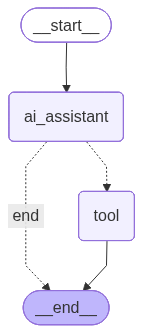

In [111]:
graph.compile()